In [119]:
import zipfile
import xarray as xr
import netCDF4 as nc
import io
import re
import numpy as np
import netCDF4

from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Data should be loaded from data/raw
path = "../data/raw/RSS_Windsat_TB_L1C_20170101.zip"

In [124]:
with zipfile.ZipFile(path, "r") as zip_file:
    file_list = zip_file.namelist()

    xarray_list = []

    for file_name in file_list:
        if file_name.endswith(".nc4") or file_name.endswith(".nc4"):
            with zip_file.open(file_name) as nc_file:
                pointer = nc_file.read()
                data = io.BytesIO(pointer)
                xarray = xr.open_dataset(data, decode_times=False, decode_coords="all")

                # Also pass time
                variables = [
                    "tb_18",
                    "tb_37",
                    "time",
                    "latitude",
                    "longitude",
                    "quality_flag",
                    "earth_incidence_angle",
                    "scan_angle",
                    "earth_azimuth_angle",
                    "pra",
                ]
                xarray = xarray[variables]

                # Get the pass id from the filename
                pattern = r"_r(\d{5})_"
                pass_id = re.findall(pattern, file_name)
                xarray["pass_id"] = pass_id

                # # Generate lat and long values
                lat = np.linspace(-90, 90, num=xarray.sizes["ydim_grid"])
                lon = np.linspace(-180, 180, num=xarray.sizes["xdim_grid"])
                # Convert longitude variable into (-180, 180) degrees
                xarray['longitude'] = (xarray["longitude"] + 180 ) % 360 - 180
                
                # xarray = xarray.assign_coords(lattitude = lat, longitude = lon)

                # Keep only H and V polarizations, also look = 0 (forward) has better coverage
                xarray["tb_18_V"] = xarray["tb_18"].sel(
                    polarization_6=0, look=0
                )  # 0 = V
                xarray["tb_18_H"] = xarray["tb_18"].sel(
                    polarization_6=1, look=0
                )  # 1 = H

                xarray = xarray.drop_vars("tb_18")

                xarray["tb_37_V"] = xarray["tb_37"].sel(
                    polarization_6=0, look=0
                )  # 0 = V
                xarray["tb_37_H"] = xarray["tb_37"].sel(
                    polarization_6=1, look=0
                )  # 1 = H

                xarray = xarray.drop_vars("tb_37")

                xarray_list.append(xarray)

print(len(xarray_list))
# For testing
xarr = xarray_list[5]
xarr

13


<xarray.Dataset> Size: 1GB
Dimensions:                (ydim_grid: 1440, xdim_grid: 3120, look: 2,
                            frequency_band: 5, pass_id: 1)
Coordinates:
  * pass_id                (pass_id) <U5 20B '72429'
Dimensions without coordinates: ydim_grid, xdim_grid, look, frequency_band
Data variables:
    time                   (ydim_grid, xdim_grid, look, frequency_band) float64 359MB ...
    latitude               (ydim_grid, xdim_grid) float32 18MB ...
    longitude              (ydim_grid, xdim_grid) float32 18MB -104.9 ... -134.8
    quality_flag           (ydim_grid, xdim_grid, look, frequency_band) int8 45MB ...
    earth_incidence_angle  (ydim_grid, xdim_grid, look, frequency_band) float32 180MB ...
    scan_angle             (ydim_grid, xdim_grid, look, frequency_band) float32 180MB ...
    earth_azimuth_angle    (ydim_grid, xdim_grid, look, frequency_band) float32 180MB ...
    pra                    (ydim_grid, xdim_grid, look, frequency_band) float32 180MB ...
    tb_18_V                (ydim_grid, xdim_grid) float32 18MB ...
    tb_18_H                (ydim_grid, xdim_grid) float32 18MB ...
    tb_37_V                (ydim_grid, xdim_grid) float32 18MB ...
    tb_37_H                (ydim_grid, xdim_grid) float32 18MB ...
Attributes: (12/76)
    Conventions:                                 CF-1.7
    title:                                       RSS WindSat TOA Brightness T...
    version:                                     V08.0
    summary:                                     The dataset contains the Lev...
    references:                                   [1] T. Meissner and F. Went...
    acknowledgement:                             Funded under NASA Grant 80NS...
    ...                                          ...
    build_dmrpp_metadata.build_dmrpp:            3.20.13-184
    build_dmrpp_metadata.bes:                    3.20.13-184
    build_dmrpp_metadata.libdap:                 libdap-3.20.11-59
    build_dmrpp_metadata.configuration:          \n# TheBESKeys::get_as_confi...
    build_dmrpp_metadata.invocation:             build_dmrpp -c /tmp/bes_conf...
    history_json:                                [{"$schema":"https:\/\/harmo...

In [70]:
variables = [
    "tb_18_V",
    "tb_37_V",
    "time",
    "quality_flag",
    "earth_incidence_angle",
    "scan_angle",
    "earth_azimuth_angle",
    "pra",
]

# Recover the size of the new grid

for var in variables:
    xarr[var] = xarr[var].interp(ydim_grid=xarr.lattitude, xdim_grid=xarr.longitude)

In [23]:
# time = seconds since 2000-01-01 00:00:00


def ConvertTime(seconds: float) -> datetime:
    """time = seconds since 2000-01-01 00:00:00"""
    start = datetime(2000, 1, 1, 0, 0, 0, 0)
    time_to_add = timedelta(seconds=seconds)

    corrected_time = start + time_to_add

    return corrected_time

In [ ]:
for xarr in xarray_list:
    print(xarr.time_coverage_start)
    print(xarr.time_coverage_end)
    print()

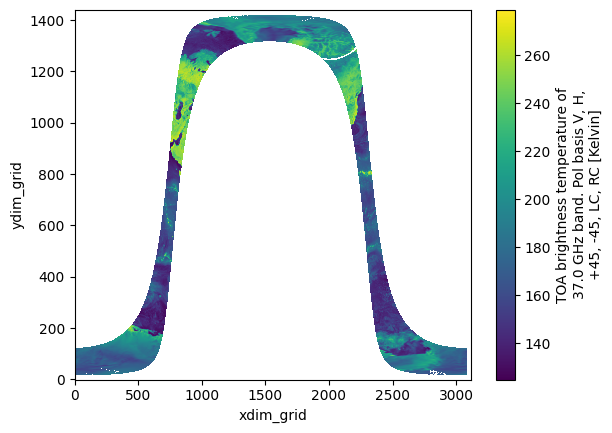

In [92]:
xarr = xarray_list[9]
KabandH = xarr["tb_37_H"]
KabandH.plot()

C:\Users\andre\AppData\Local\Temp\ipykernel_9896\2825686872.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


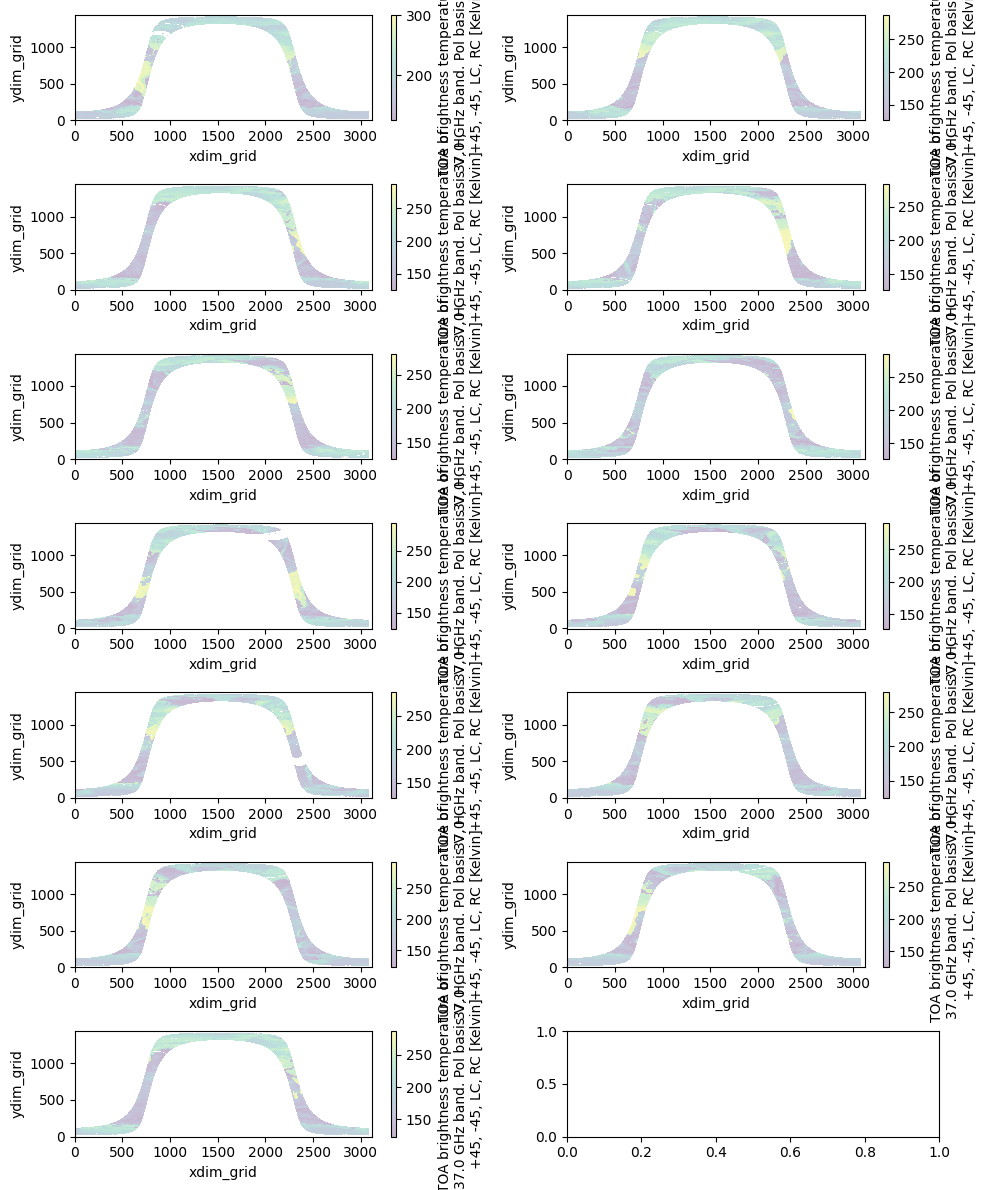

In [47]:
%time
# Plot all the passes in the same plot: Tb_ka_H
ncols = 2
nrows = (
    len(xarray_list) // 2 + 1 if len(xarray_list) % 2 == 1 else len(xarray_list) // 2
)

fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(10, 12))
for i, xarr in enumerate(xarray_list):
    row = i // ncols
    col = i % ncols
    to_plot = xarr["tb_37_H"]
    to_plot.plot(ax=ax[row, col], cmap="viridis", alpha=0.3)

fig.tight_layout()